# 5. 감성 분석

### 감성 분석 소개
* 감성 분석(Sentiment Analysis)은 문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위한 방법으로 소셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 다양한 분야에서 활용되고 있음
* `지도 학습 기반의 분석`
 * 지도학습은 학습 데이터와 타깃 레이블 값을 기반으로 감성 분석 학습을 수행한 뒤 이를 기반으로 다른 데이터의 감성 분석을 예측하는 방법으로 일반적인 텍스트 기반의 분류와 거의 동일
* `비지도 학습 기반의 분석` : 감성 어휘 사전을 이용한 분석
 * 감성 어휘 사전은 감성 분석을 위한 용어와 문맥에 대한 다양한 정보를 가지고 있으며, 이를 이용해 문서의 긍정적, 부정적 감성 여부를 판단, 문서 내 텍스트가 나타내는 여러 가지 주관적인 단어와 문맥을 기반으로 감성(Sentiment) 수치를 계산하는 방법을 이용

### 지도학습 기반 감성 분석 실습 - IMDB 영화평

* 영화 리뷰에 대한 긍정/부정 예측

In [28]:
import pandas as pd

review_df = pd.read_csv('./labeledTrainData.tsv', header = 0, sep = '\t', quoting = 3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [29]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

* 데이터 사전 처리 html 태그 제거 및 숫자 문자 제거

In [30]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용하여 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

* 학습/테스트 데이터 분리

In [31]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size = 0.3, random_state = 156)

X_train.shape, X_test.shape

((17500, 1), (7500, 1))

* Pipeline을 통해 Count 기반 피처 벡터화 및 머신러닝 학습/예측/평가

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, filtering, ngram은 (1, 2)로 설정해 CountVectorization 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([('cnt_vect', CountVectorizer(stop_words = 'english', ngram_range = (1, 2))),
                     ('lr_clf', LogisticRegression(C = 10))])

# Pipeline 객체를 이용하여 fit(), predict()로 학습/예측 수행, predict_proba()는 roc_auc 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도는 0.8860, ROC-AUC는 0.9503


* Pipeline을 통해 TF-IDF 기반 피처 벡터화 및 머신러닝 학습/예측/평가

In [12]:
# 스톱 워드는 English, filtering, ngram은 (1, 2)로 설정해 TF-IDF 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([('tfidf_vect', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))),
                     ('lr_clf', LogisticRegression(C = 10))])

# Pipeline 객체를 이용하여 fit(), predict()로 학습/예측 수행, predict_proba()는 roc_auc 때문에 수행
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


### 비지도학습 기반 감성 분석 소개

* 감성 어휘 사전 기반의 감성 분석
 * SentiWordNet
   * NLTK 패키지의 WordNet과 유사하게 감성 단어 전용의 WordNet을 구현한 것, SentiWordNet은 Synset별로 3가지 감성 점수(sentiment score)를 할당
   * 긍정 감성 지수, 부정 감성 지수, 객관성 지수
   * 긍정 감성 지수는 해당 단어가 감성적으로 얼마나 긍정적인가
   * 부정 감정 지수는 얼마나 감성적으로 부정적인가를 수치로 나타낸 것
   * 객관성 지수는 긍정/부정 감성 지수와 완전히 반대되는 개념으로 단어가 감성과 관계없이 얼마나 객관적인지를 수치로 나타낸 것
   * 문장별로 단어들의 긍정 감성 지수와 부정 감성 지수를 합산하여 최종 감성 지수를 계산하고 이에 기반해 감성이 긍정인지 부정인지를 결정
  
 * VADER : 주로 소셜 미디어의 텍스트에 대한 감성 분석을 제공하기 위한 패키지, 뛰어난 감성 분석 결과를 제공하며, 비교적 빠른 수행 시간을 보장해 대용량 텍스트 데이터에 잘 사용되는 패키지임
 
 * Pattern : 예측 성능 측면에서 가장 주목받는 패키지임, 아쉽게도 현재 기준으로 파이썬 3.X 버전에서 호환이 되지 않고, 파이썬 2.X 버전에서만 동작

* SentiWordNet의 감성 지수<br>
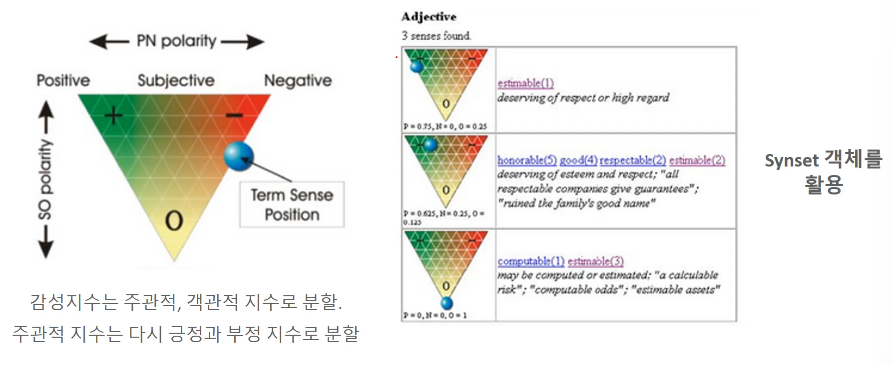

* SentiWordNet을 이용한 감성 분석
 * 1. 문서(Document)를 문장(Sentence) 단위로 분해
 * 2. 다시 문장을 단어(Word) 단위로 토큰화하고 품사 태킹
 * 3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
 * 4. Senti_synset에서 긍정 감성/부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성으로, 그렇지 않을 때는 부정 감성으로 결정

* VADER
 * VADER는 소셜 미디어의 감성 분석 용도로 만들어진 룰 기반의 Lexicon임
 * VADER는 SentimentIntensityAnalyzer 클래스를 이용해 쉽게 감성 분석을 제공
 * SentimentIntensityAnalyzer 객체를 생성한 뒤에 문서별로 `polarity_scores()` 메서드를 호출해 감성 점수를 구한 뒤, 해당 문서의 감성 점수가 특정 임계값 이상이면 긍정, 그렇지 않으면 부정으로 판단
 * 'neg'는 부정 감성 지수, 'neu'는 중립적인 감성 지수, 'pos'는 긍정 감성 지수, 그리고 compound는 neg, neu, pos score를 적절히 조합해 -1에서 1 사이의 감성 지수를 표현
 * compound score를 기반으로 부정 감성 또는 긍정 감성 여부를 결정함, 보통 0.1 이상이면 긍정 감성, 그 이하이면 부정감성으로 판단하나 상황에 따라 이 임계값을 적절히 조정해 예측 성능을 조절

### SentiWordNet을 이용한 감성 분석

In [13]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | Downloading package names to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Downloading package nombank.1.0 to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nombank.1.0 is already up-to-date!
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps_chat to
[

[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_tagset to
[nltk_data]    |     C:\Users\gram\AppData\Roaming\nltk_data...
[nltk_data]    |   Package universal_tagset is already up-to-date!
[nltk_data]    | Downloading package universal_tree

True

* synsets() 호출
 * 호출 시 반환되는 것은 여러 개의 synset 객체를 가지는 리스트
 * 총 18개의 서로 다른 sematic을 가지는 synset 객체가 반환됨
 * 'present.n.01'은 POS 태그를 의미하는데, present는 의미, n은 명사 품사, 01은 present가 명사로서 가지는 의미가 여러 가지 있어서 이를 구분하는 인덱스
 * synset 객체는 POS(품사), 정의, 부명제 등으로 시맨틱적인 요소를 표현 가능

In [14]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 개수 :', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 개수 : 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


In [15]:
for synset in synsets:
    print('##### Synset name :', synset.name(), '#####')
    print('POS :', synset.lexname())
    print('Definition :', synset.definition())
    print('Lemmas :', synset.lemma_names())

##### Synset name : present.n.01 #####
POS : noun.time
Definition : the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas : ['present', 'nowadays']
##### Synset name : present.n.02 #####
POS : noun.possession
Definition : something presented as a gift
Lemmas : ['present']
##### Synset name : present.n.03 #####
POS : noun.communication
Definition : a verb tense that expresses actions or states at the time of speaking
Lemmas : ['present', 'present_tense']
##### Synset name : show.v.01 #####
POS : verb.perception
Definition : give an exhibition of to an interested audience
Lemmas : ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name : present.v.02 #####
POS : verb.communication
Definition : bring forward and present to the mind
Lemmas : ['present', 'represent', 'lay_out']
##### Synset name : stage.v.01 #####
POS : verb.creation
Definition : perform (a play), especially on a stage
Lemmas : ['stage', 'present', 're

=> 이처럼 synset은 하나의 단어가 가질 수 있는 여러가지 시맨틱 정보를 개별 클래스로 나타냄

* WordNet은 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타낼 수 있음
 * synset 객체는 단어 간의 유사도를 나타내기 위해서 path_similarity() 메서드를 제공

In [16]:
# synset 객체를 단어별로 생성
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset 유사도를 측정
for entity in entities:
    similarity = [round(entity.path_similarity(compared_entity), 2)
                  for compared_entity in entities]
    similarities.append(similarity)
    
# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame 형태로 저장
similarity_df = pd.DataFrame(similarities, columns = entity_names, index = entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


* WordNet의 Synset과 유사한 SentiWordNet의 Senti_Synset 클래스

In [17]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 개수 :', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 개수 : 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


In [19]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수 :', father.pos_score())
print('father 부정감성 지수 :', father.neg_score())
print('father 객관성 지수 :', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수 :', fabulous.pos_score())
print('fabulous 부정감성 지수 :', fabulous.neg_score())
print('fabulous 객관성 지수 :', fabulous.obj_score())

father 긍정감성 지수 : 0.0
father 부정감성 지수 : 0.0
father 객관성 지수 : 1.0


fabulous 긍정감성 지수 : 0.875
fabulous 부정감성 지수 : 0.125
fabulous 객관성 지수 : 0.0


### SentiWordNet을 이용한 영화 감상평 분석 (p.529, 생략)

* 품사 태깅을 수행하는 내부 함수 생성

In [25]:
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag를 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB

* Polarity Score를 합산하는 함수 생성

In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화
    sentiment = 0.0
    tokens_count = 0
    
    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
    for raw_sentence in raw_sentences:
        # NLTK 기반의 품사 태깅 문장 추출
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word, tag in tagged_sentence:
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos = wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성
            synsets = wn.synsets(lemma, pos = wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로, 부정 감성 지수는 -로 합산해 감성 지수 계산
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_socre())
            tokens_count += 1

    if not tokens_count:
        return 0

    # 총 score가 0 이상일 경우 긍정 1, 그렇지 않을 경우 부정 0 반환
    if sentiment >= 0:
        return 1
    
    return 0

* swn_polarity(text) 함수를 IMDB 감상평의 개별 문서에 적용해 긍정 및 부정 감서을 예측

In [35]:
train_df['preds'] = train_df['review'].apply(lambda x: swn_polarity(x))
y_target = train_df['sentiment'].values
preds = train_df['preds'].values

NameError: name 'train_df' is not defined

* SentiWordNet의 감성 분석 예측 성능

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print('정확도 :', accuracy_score(y_target, preds))
print('정밀도 :', precision_score(y_target, preds))
print('재현율 :', recall_score(y_target, preds))

NameError: name 'preds' is not defined

___

### VADER를 이용한 감성 분석

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [22]:
def vader_polarity(review, threshold = 0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity()를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply(lambda x: vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

In [23]:
print('#### VADER 예측 성능 평가 ####')

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

print(confusion_matrix(y_target, vader_preds))
print('정확도 :', accuracy_score(y_target, vader_preds))
print('정밀도 :', precision_score(y_target, vader_preds))
print('재현율 :', recall_score(y_target, vader_preds))

#### VADER 예측 성능 평가 ####
[[ 6747  5753]
 [ 1858 10642]]
정확도 : 0.69556
정밀도 : 0.6491003354681305
재현율 : 0.85136


# 6. 토픽 모델링(Topic Modeling) - 20 뉴스그룹

* 토픽 모델링은 문서드렝 잠재되어 있는 공통된 토픽(주제)들을 추출해내는 기법을 의미
* 공통된 유사성을 도출한다는 측면에서 문서 군집화/유사도와 비슷한 기법일 수 있지만, 토픽 모델링은 문서들이 가지는 주요 토픽의 분포도와 개별 토픽이 어떤 의미인지를 제공하는 특징을 가지고 있음<br>
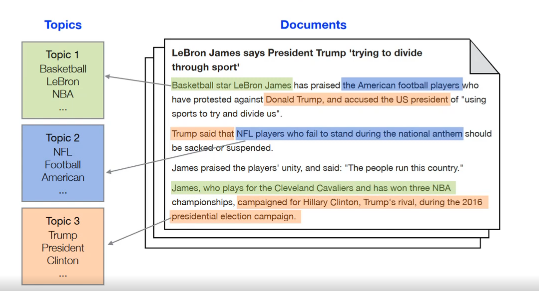

* 토픽 모델링의 이해<br>
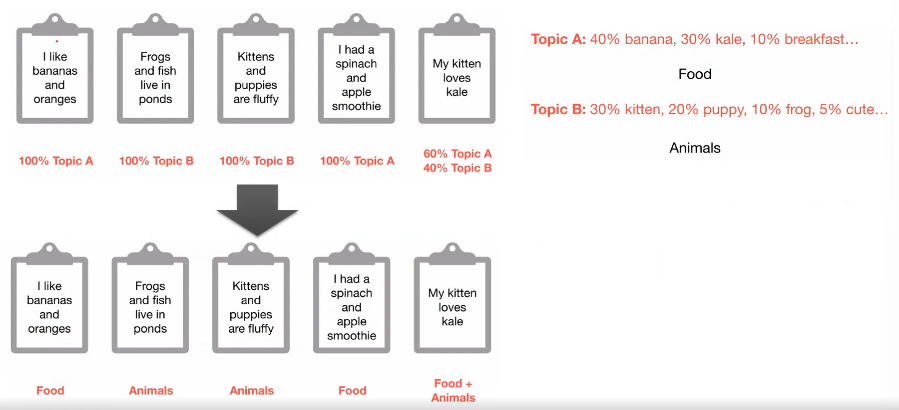

* 토픽 모델링 알고리즘 유형<br>
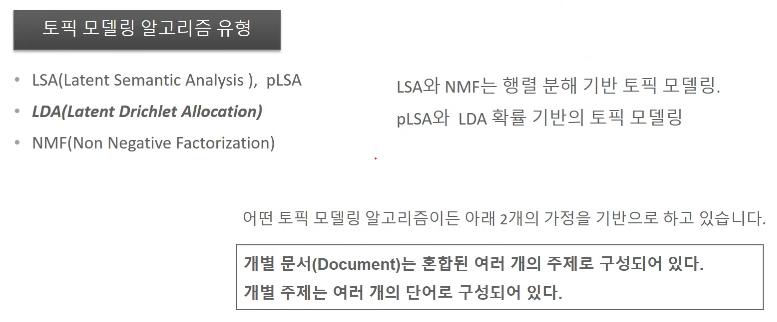

* 행렬 분해 기반과 확률 기반 토픽 모델링<br>
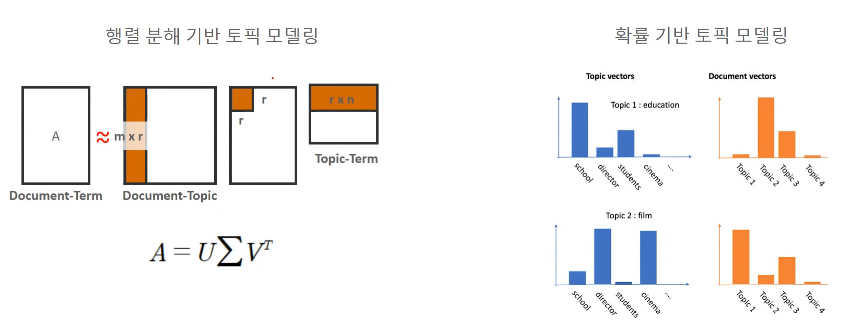

* LDA(Latent Dirichlet Allocation)의 이해<br>
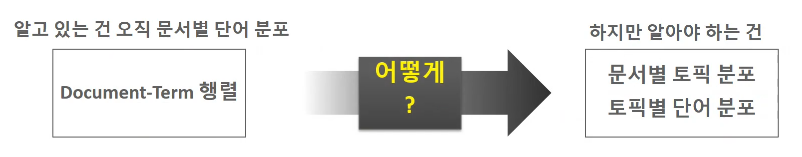<br>
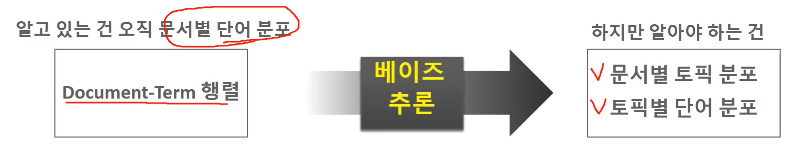<br>
 * LDA는 관찰된 문서 내 단어들을 이용하여 베이즈 추론을 통해 잠재된 문서 내 토픽 분포와 토픽별 단어 분포를 추론하는 방식
 * 이 때, LDA 베이즈 추론의 사전 확률분포로 사용되는 것이 디리클레 분포(Dirichlet Distribution)임

* 베이즈 추론 켤레 사전 분포<br>
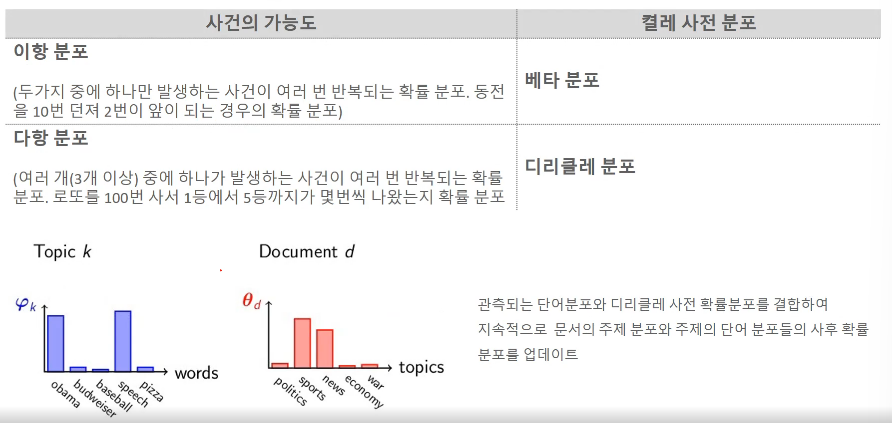

* LDA 구성 요소<br>
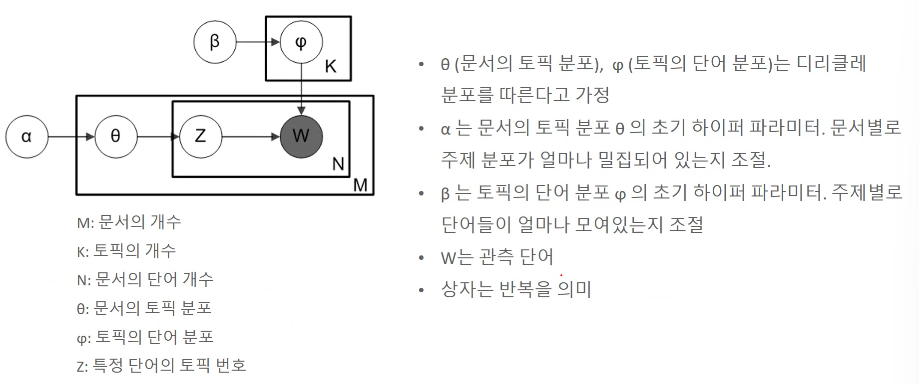

In [37]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 등 8개 주제를 추출. 
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med'  ]

# 위에서 cats 변수로 기재된 category만 추출. featch_20newsgroups( )의 categories에 cats 입력
news_df= fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'), 
                            categories=cats, random_state=0)

#LDA 는 Count기반의 Vectorizer만 적용합니다.  
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [38]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

In [39]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [40]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' + '.join([str(feature_names[i])+'*'+str(round(topic[i],1)) for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topic_words(lda, feature_names, 15)

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 등 8개 주제를 추출. 


Topic # 0
year*703.2 + 10*563.6 + game*476.3 + medical*413.2 + health*377.4 + team*346.8 + 12*343.9 + 20*340.9 + disease*332.1 + cancer*319.9 + 1993*318.3 + games*317.0 + years*306.5 + patients*299.8 + good*286.3

Topic # 1
don*1454.3 + just*1392.8 + like*1190.8 + know*1178.1 + people*836.9 + said*802.5 + think*799.7 + time*754.2 + ve*676.3 + didn*675.9 + right*636.3 + going*625.4 + say*620.7 + ll*583.9 + way*570.3

Topic # 2
image*1047.7 + file*999.1 + jpeg*799.1 + program*495.6 + gif*466.0 + images*443.7 + output*442.3 + format*442.3 + files*438.5 + color*406.3 + entry*387.6 + 00*334.8 + use*308.5 + bit*308.4 + 03*258.7

Topic # 3
like*620.7 + know*591.7 + don*543.7 + think*528.4 + use*514.3 + does*510.2 + just*509.1 + good*425.8 + time*417.4 + book*410.7 + read*402.9 + information*395.2 + people*393.5 + used*388.2 + post*368.4

Topic # 4
armenian*960.6 + israel*815.9 + armenians*699.7 + jews*690.9 + turkish*686.1 + people*653.0 + israeli*476.1 + jewish*467.0 + government*464.4 + wa

C:\Users\gram\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
doc_topics = lda.transform(feat_vect)
print(doc_topics.shape)
print(doc_topics[:3])

(7862, 8)
[[0.01389701 0.01394362 0.01389104 0.48221844 0.01397882 0.01389205
  0.01393501 0.43424401]
 [0.27750436 0.18151826 0.0021208  0.53037189 0.00212129 0.00212102
  0.00212113 0.00212125]
 [0.00544459 0.22166575 0.00544539 0.00544528 0.00544039 0.00544168
  0.00544182 0.74567512]]


In [42]:
def get_filename_list(newsdata):
    filename_list=[]

    for file in newsdata.filenames:
            #print(file)
            filename_temp = file.split('\\')[-2:]
            filename = '.'.join(filename_temp)
            filename_list.append(filename)
    
    return filename_list

filename_list = get_filename_list(news_df)
print("filename 개수:",len(filename_list), "filename list 10개만:",filename_list[:10])

filename 개수: 7862 filename list 10개만: ['soc.religion.christian.20630', 'sci.med.59422', 'comp.graphics.38765', 'comp.graphics.38810', 'sci.med.59449', 'comp.graphics.38461', 'comp.windows.x.66959', 'rec.motorcycles.104487', 'sci.electronics.53875', 'sci.electronics.53617']


In [43]:
import pandas as pd 

topic_names = ['Topic #'+ str(i) for i in range(0, 8)]
doc_topic_df = pd.DataFrame(data=doc_topics, columns=topic_names, index=filename_list)
doc_topic_df.head(20)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7
soc.religion.christian.20630,0.013897,0.013944,0.013891,0.482218,0.013979,0.013892,0.013935,0.434244
sci.med.59422,0.277504,0.181518,0.002121,0.530372,0.002121,0.002121,0.002121,0.002121
comp.graphics.38765,0.005445,0.221666,0.005445,0.005445,0.005440,0.005442,0.005442,0.745675
comp.graphics.38810,0.005439,0.005441,0.005449,0.578959,0.005440,0.388387,0.005442,0.005442
sci.med.59449,0.006584,0.552000,0.006587,0.408485,0.006585,0.006585,0.006588,0.006585
comp.graphics.38461,0.008342,0.008352,0.182622,0.767314,0.008335,0.008341,0.008343,0.008351
comp.windows.x.66959,0.372861,0.041667,0.377020,0.041668,0.041703,0.041703,0.041667,0.041711
rec.motorcycles.104487,0.225351,0.674669,0.004814,0.075920,0.004812,0.004812,0.004812,0.004810
sci.electronics.53875,0.008944,0.836686,0.008932,0.008941,0.008935,0.109691,0.008932,0.008938
sci.electronics.53617,0.041733,0.041720,0.708081,0.041742,0.041671,0.041669,0.041699,0.041686


# 7. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)

In [49]:
import pandas as pd
import glob ,os

# 아래는 제 컴퓨터에서 압축 파일을 풀어 놓은 디렉토리이니, 여러분의 디렉토리를 설정해 주십시요  
path = r'OpinosisDataset1.0\OpinosisDataset1.0\topics'                     
# path로 지정한 디렉토리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일내용은 DataFrame로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    
    # 절대경로로 주어진 file 명을 가공. 만일 Linux에서 수행시에는 아래 \\를 / 변경. 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]

    #파일명 리스트와 파일내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 리스트와 파일내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


In [50]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# nltk는 
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\gram\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [52]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [53]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,0
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1


In [54]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,0
32,room_holiday_inn_london,...,0
30,rooms_bestwestern_hotel_sfo,...,0
31,rooms_swissotel_chicago,...,0


In [55]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1
19,keyboard_netbook_1005ha,...,1
26,performance_netbook_1005ha,...,1
41,size_asus_netbook_1005ha,...,1
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,1
44,speed_windows7,...,1


In [56]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
5,buttons_amazon_kindle,...,2
8,directions_garmin_nuvi_255W_gps,...,2
9,display_garmin_nuvi_255W_gps,...,2
10,eyesight-issues_amazon_kindle,...,2
11,features_windows7,...,2
12,fonts_amazon_kindle,...,2
23,navigation_amazon_kindle,...,2
33,satellite_garmin_nuvi_255W_gps,...,2
34,screen_garmin_nuvi_255W_gps,...,2


In [57]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
13,food_holiday_inn_london,...,3
14,food_swissotel_chicago,...,3
15,free_bestwestern_hotel_sfo,...,3
20,location_bestwestern_hotel_sfo,...,3
21,location_holiday_inn_london,...,3
24,parking_bestwestern_hotel_sfo,...,3
27,price_amazon_kindle,...,3
28,price_holiday_inn_london,...,3
38,service_bestwestern_hotel_sfo,...,3
39,service_holiday_inn_london,...,3


In [58]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,...,4
7,comfort_toyota_camry_2007,...,4
16,gas_mileage_toyota_camry_2007,...,4
17,interior_honda_accord_2008,...,4
18,interior_toyota_camry_2007,...,4
22,mileage_honda_accord_2008,...,4
25,performance_honda_accord_2008,...,4
29,quality_toyota_camry_2007,...,4
37,seats_honda_accord_2008,...,4
47,transmission_toyota_camry_2007,...,4


In [59]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,0
48,updates_garmin_nuvi_255W_gps,...,0
44,speed_windows7,...,0
43,speed_garmin_nuvi_255W_gps,...,0
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
41,size_asus_netbook_1005ha,...,0
36,screen_netbook_1005ha,...,0
35,screen_ipod_nano_8gb,...,0
34,screen_garmin_nuvi_255W_gps,...,0
33,satellite_garmin_nuvi_255W_gps,...,0


In [60]:
feature_vect.shape

(51, 4611)

In [61]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]]


In [62]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details


In [63]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [64]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']
####### Cluster 1
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord_2008', 'interior_toyota_camry_2007', 'mileage_honda_accord_2008', 'performance_honda_accord_2008']
####### Cluster 2
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_h

C:\Users\gram\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 8. 문서 유사도

In [66]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [68]:
print(type(feature_vect_simple))

<class 'scipy.sparse.csr.csr_matrix'>


In [70]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [71]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [72]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [73]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [74]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [75]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [77]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'OpinosisDataset1.0\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\gram\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [78]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([6, 7, 16, 17, 18, 22, 25, 29, 37, 47], dtype='int64')
##### 비교 기준 문서명  comfort_honda_accord_2008  와 타 문서 유사도######
[[1.         0.83969704 0.15655631 0.33044002 0.25981841 0.16544257
  0.27569738 0.18050974 0.65502034 0.06229873]]


[[1 8 3 6 4 7 5 2 9]]
Int64Index([6, 7, 16, 17, 18, 22, 25, 29, 37, 47], dtype='int64')


Text(0.5, 1.0, 'comfort_honda_accord_2008')

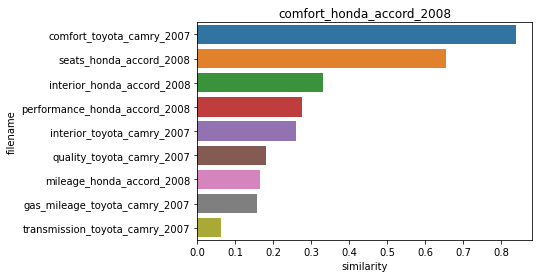

In [79]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]
print(sorted_index)

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
print(hotel_indexes)
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1,)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1,))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)